In [1]:
import os
from dotenv import load_dotenv

from langchain.globals import set_verbose, set_debug
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

from utils import process_and_store_documents, build_graph
from config import LOCAL_LLM, URLS
from config import RetrievalGrader_prompt, generate_prompt, HallucinationGrader_prompt, AnswerGrader_prompt, Router_prompt
from nodes import Nodes

load_dotenv()

set_debug(True)
set_verbose(True)

USER_AGENT environment variable not set, consider setting it to identify your requests.
/home/ollama_platform/TaiwanScamDetect/Agentic_RAG/config.py:10: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  LOCAL_LLM = ChatOllama(model="llama3.2:3b", format="json", temperature=0)


In [2]:
retriever = process_and_store_documents(URLS)

/home/ollama_platform/TaiwanScamDetect/Agentic_RAG/utils.py:36: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding=HuggingFaceEmbeddings(),
/home/ollama_platform/TaiwanScamDetect/Agentic_RAG/utils.py:36: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding=HuggingFaceEmbeddings(),
/home/ollama_platform/miniconda3/envs/AgenticRAG/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets

In [3]:
retrieval_grader = RetrievalGrader_prompt | LOCAL_LLM | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "agent memory",
  "document": "Each element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)\n\nPrompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.\n\n\nPl

In [4]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = generate_prompt | LOCAL_LLM | StrOutputParser()

# Run
question = "agent memory"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:RunnableSequence > prompt:PromptTemplate] Entering Prompt run with input:
[inputs]
[chain/end] [chain:RunnableSequence > prompt:PromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: You are an assistant for question-answering tasks. \n    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. \n    Use three sentences maximum and keep the answer concise:\n    Question: agent memory \n    Context: [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stor

In [5]:
hallucination_grader = HallucinationGrader_prompt | LOCAL_LLM | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:RunnableSequence > prompt:PromptTemplate] Entering Prompt run with input:
[inputs]
[chain/end] [chain:RunnableSequence > prompt:PromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: You are a grader assessing whether \n    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate \n    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a \n    single key 'score' and no preamble or explanation.\n    \n    Here are the facts:\n    [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potential

{}

In [6]:
answer_grader = AnswerGrader_prompt | LOCAL_LLM | JsonOutputParser()
answer_grader.invoke({"question": question,"generation": generation})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "agent memory",
  "generation": "{}"
}
[chain/start] [chain:RunnableSequence > prompt:PromptTemplate] Entering Prompt run with input:
{
  "question": "agent memory",
  "generation": "{}"
}
[chain/end] [chain:RunnableSequence > prompt:PromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: You are a grader assessing whether an \n    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is \n    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.\n     \n    Here is the answer:\n    {} \n\n    Here is the question: agent memory"
  ]
}
[llm/end] [chain:RunnableSequence > llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "

{'score': 'no'}

In [7]:
question_router = Router_prompt | LOCAL_LLM | JsonOutputParser()
question = "llm agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "llm agent memory"
}
[chain/start] [chain:RunnableSequence > prompt:PromptTemplate] Entering Prompt run with input:
{
  "question": "llm agent memory"
}
[chain/end] [chain:RunnableSequence > prompt:PromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: You are an expert at routing a \n    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents, \n    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords \n    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' \n    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and \n    no premable or explaination. \n    \n    Question to route: \n    llm agent memory"
  ]
}
[llm/e

/tmp/ipykernel_3830599/622595501.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


In [8]:
### Search
os.environ["TAVILY_API_KEY"] = "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"

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [9]:
nodes = Nodes(
        retriever=retriever,
        rag_chain=rag_chain,
        retrieval_grader=retrieval_grader,
        web_search_tool=web_search_tool,
        question_router=question_router,
        hallucination_grader=hallucination_grader,
        answer_grader=answer_grader
    )

workflow = build_graph(nodes)
app = workflow.compile()    # Compile

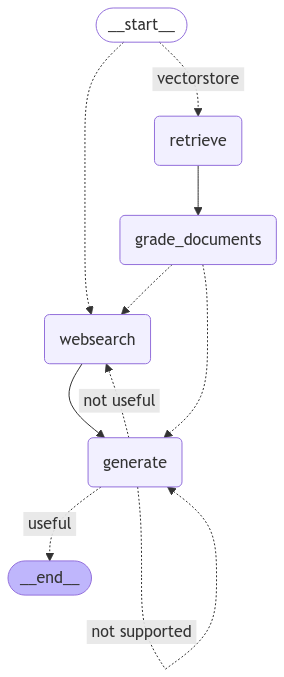

In [10]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
from langchain_core.runnables import RunnableConfig
config = RunnableConfig(recursion_limit=50)

# Test
from pprint import pprint
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs, config):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "question": "What are the types of agent memory?"
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "question": "What are the types of agent memory?"
}
[chain/start] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<question,generation,web_search,documents>] Entering Chain run with input:
{
  "question": "What are the types of agent memory?"
}
[chain/end] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<question,generation,web_search,documents>] s] Exiting Chain run with output:
{
  "question": "What are the types of agent memory?"
}
[chain/start] [chain:LangGraph > chain:__start__ > chain:route_question] Entering Chain run with input:
{
  "question": "What are the types of agent memory?"
}
---ROUTE QUESTION---
[chain/start] [chain:LangGraph > chain:__start__ > chain:route_question > chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What are the typ

GraphRecursionError: Recursion limit of 50 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT